In [ ]:
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import yfinance as yf

warnings.filterwarnings("ignore")

In [ ]:
# Fetch historical data for specified cryptocurrencies over the last 4 years.
coin_list = ["DOGE-USD", "BTC-USD", "ETH-USD", "LTC-USD"]
coin_df = pd.DataFrame()

end = dt.now()
start = dt(end.year-4, end.month, end.day)

for coin in coin_list:
  temp = yf.download(coin, start, end)
  temp['ticker'] = coin
  coin_df = pd.concat([coin_df, temp])

# Map cryptocurrency tickers to full names and remove the ticker column.
coin_df["name"] = coin_df["ticker"].map({"DOGE-USD": "Dodgecoin", "BTC-USD": "Bitcoin",
                                           "ETH-USD": "Ethereum", "LTC-USD":"Litecoin"})
coin_df.drop(columns="ticker", inplace=True)

# Display the first six rows of the consolidated DataFrame.
coin_df.head(6)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,name
Date,,,,,,,
2019-09-01,0.002512,0.002533,0.002443,0.002492,0.002492,22742519,Dodgecoin
2019-09-02,0.002492,0.002616,0.002462,0.002596,0.002596,25999239,Dodgecoin
2019-09-03,0.002598,0.002724,0.002560,0.002595,0.002595,40548612,Dodgecoin
2019-09-04,0.002596,0.002695,0.002541,0.002690,0.002690,27623103,Dodgecoin
2019-09-05,0.002690,0.002692,0.002505,0.002531,0.002531,32285101,Dodgecoin
2019-09-06,0.002529,0.002640,0.002460,0.002509,0.002509,29577777,Dodgecoin


In [ ]:
# Display DataFrame structure and plot adjustments for visualization.
coin_df.info()  
plt.tight_layout()  

# Calculate and display the total number of missing values for each cryptocurrency.
coin_df.groupby("name").agg(lambda x: x.isna().sum()).sum(axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5848 entries, 2019-09-01 to 2023-09-01
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5848 non-null   float64
 1   High       5848 non-null   float64
 2   Low        5848 non-null   float64
 3   Close      5848 non-null   float64
 4   Adj Close  5848 non-null   float64
 5   Volume     5848 non-null   int64  
 6   name       5848 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 365.5+ KB


name
Bitcoin      0
Dodgecoin    0
Ethereum     0
Litecoin     0
dtype: int64

<Figure size 640x480 with 0 Axes>

# **Visualization**

## Original Price Data



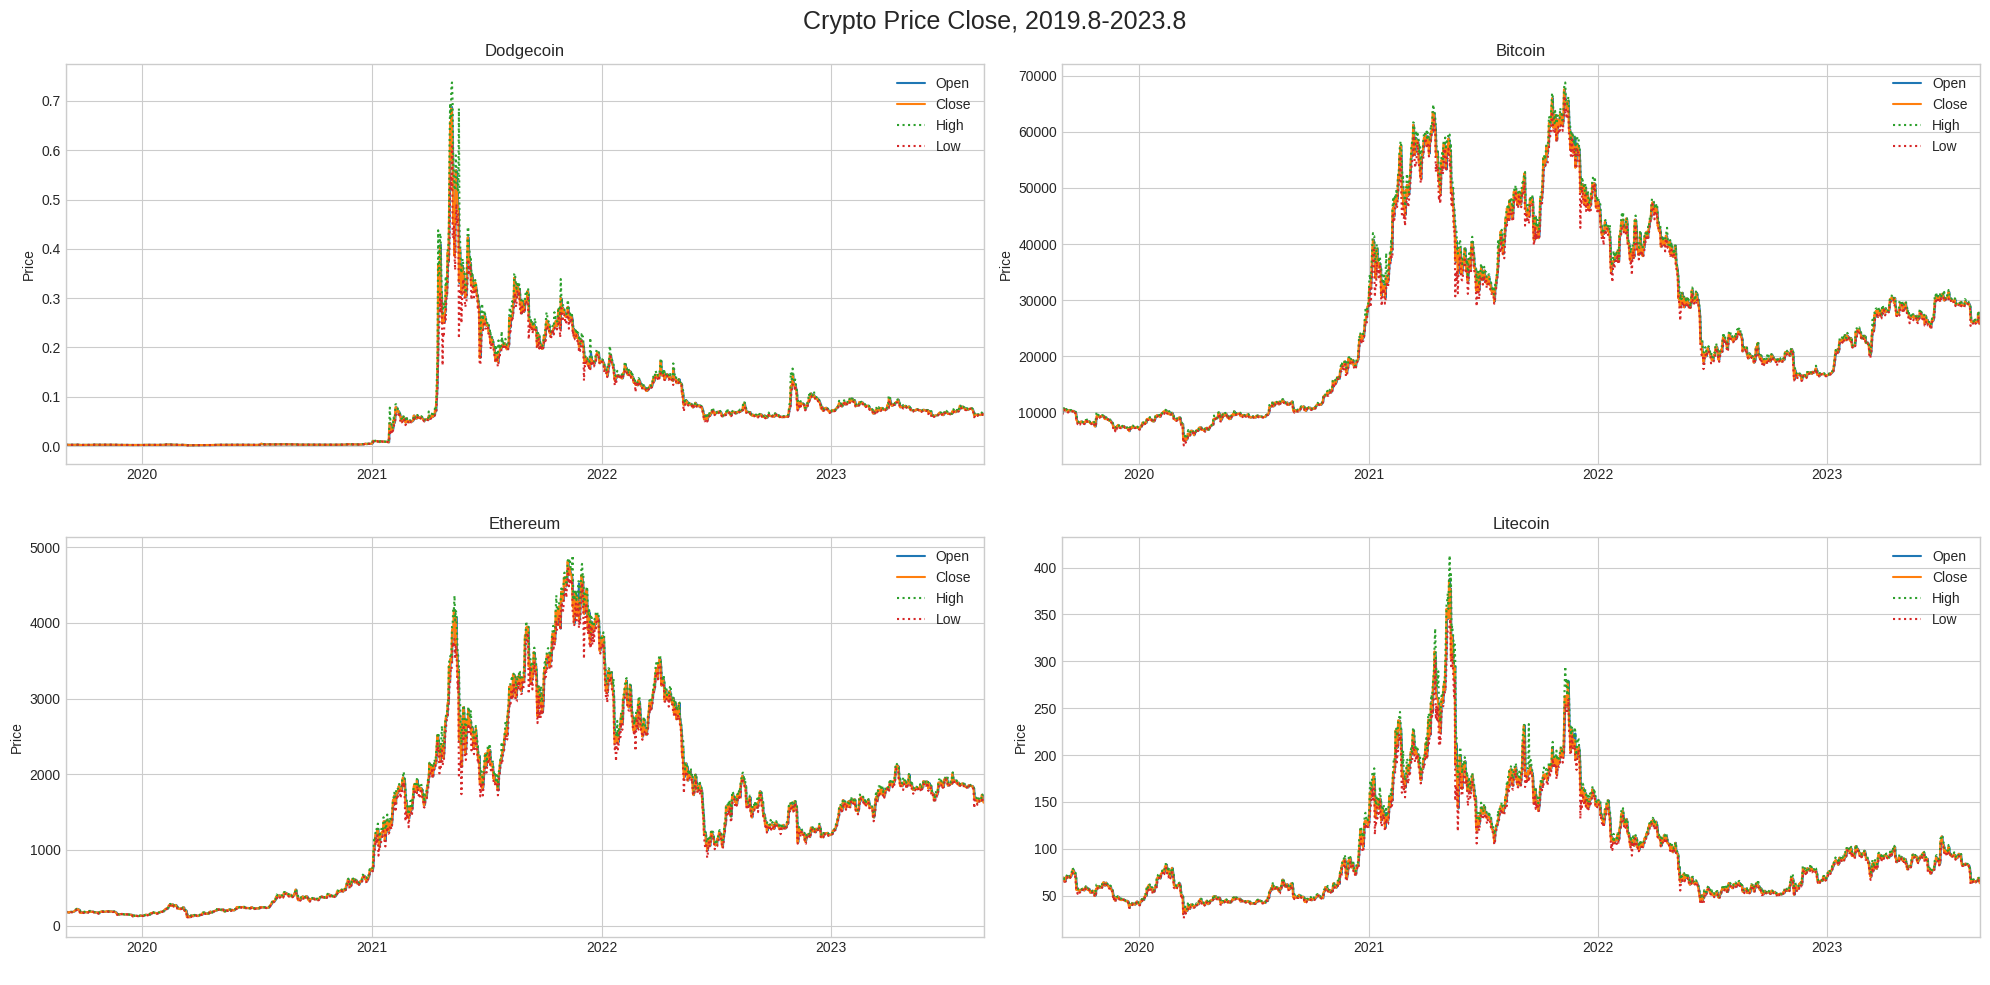

In [ ]:
# Set plot style and initialize a figure for plotting cryptocurrency price trends.
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(20,10))
plt.subplots

# Plot Open, Close, High, and Low prices for each cryptocurrency.
for i, name in enumerate(coin_df.name.unique(), 1):
  plt.subplot(2,2,i)
  coin_df['Open'][coin_df.name == name].plot(label="Open")
  coin_df['Close'][coin_df.name == name].plot(label="Close")
  coin_df['High'][coin_df.name == name].plot(label="High", linestyle=':')
  coin_df['Low'][coin_df.name == name].plot(label="Low", linestyle=':')

  plt.ylabel('Price')
  plt.xlabel(' ')
  plt.title("{0}".format(name))
  plt.legend(loc='upper right')

# Finalize and display the plot with an overarching title.
plt.suptitle('Crypto Price Close, 2019.8-2023.8', fontsize=18)
plt.tight_layout()

## Scaled Price Data


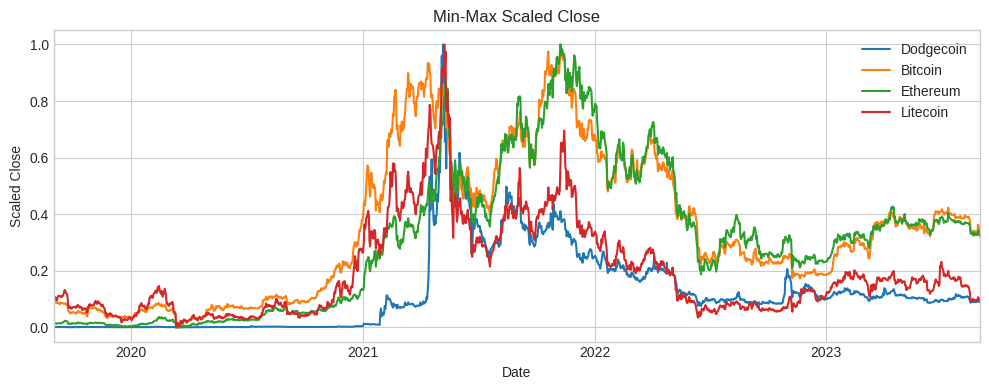

In [ ]:
# Define function to scale data using MinMaxScaler.
def min_max_scaler(data):
  scaler = MinMaxScaler(feature_range=(0,1))
  try:
    return scaler.fit_transform(data)
  except:
    return scaler.fit_transform(data.values.reshape(-1,1))

# Apply MinMaxScaler to the 'Close' price of each cryptocurrency in the DataFrame.
scaled_df = coin_df[['Close', 'name']]
for coin_name in ['Bitcoin', 'Dodgecoin', 'Ethereum', 'Litecoin']:
    scaled_close = min_max_scaler(coin_df["Close"][coin_df["name"] == coin_name])
    scaled_df['Close'][scaled_df.name == coin_name] = scaled_close.reshape(-1,)

# Plot scaled 'Close' prices for comparison.
plt.figure(figsize=(10,4))
for coin_name in ['Bitcoin', 'Dodgecoin', 'Ethereum', 'Litecoin']:
    scaled_df['Close'][scaled_df.name == coin_name].plot(label=coin_name)

plt.xlabel("Date")
plt.ylabel("Scaled Close")
plt.legend()
plt.title("Min-Max Scaled Close Prices of Cryptocurrencies")
plt.tight_layout()

# **Data Preprocessing**

In [ ]:
# Define function to create sequences (X) and targets (y) from time-series data.
def get_Xy(X_data, y_data, n):
  if len(X_data) != len(y_data):
    raise ValueError("Incorrect input size!")

  X = []
  y = []

  for i in range(len(X_data)-n+1):
    X.append(X_data[i:i+n])
    y.append(y_data[i+n-1])

  X = np.array(X)
  print(X.shape)
  y = np.array(y)

  return X, y

# Function to split data into training, testing, and validation sets based on provided sizes.
def set_split(data, test_size=260, valid_size=160):
  N = data.shape[0]
  valid_set = data[N-valid_size+1:]
  test_set = data[N-valid_size-test_size+1:N-valid_size]
  train_set = data[:N-valid_size-test_size]

  return train_set, test_set, valid_set

# Select features for modeling and split Bitcoin data into training, testing, and validation sets.
feature_name = ["Open", "Volume", "Close", "High", "Low", "Close"]
n_feature = len(feature_name)
btc_train_Xy, btc_test_Xy, btc_valid_Xy = set_split(coin_df[feature_name][coin_df.name == "Bitcoin"])

# Scale data using Min-Max scaler to normalize feature values.
btc_scaler = MinMaxScaler(feature_range=(0,1))
btc_train_Xy = btc_scaler.fit_transform(btc_train_Xy)
btc_test_Xy = btc_scaler.transform(btc_test_Xy)
btc_valid_Xy = btc_scaler.transform(btc_valid_Xy)

# Generate input and output sequences for LSTM model from scaled data.
X_train, y_train = get_Xy(X_data = btc_train_Xy[:,:-1], y_data = btc_train_Xy[:,-1], n=60)
X_test, y_test = get_Xy(X_data = btc_test_Xy[:,:-1], y_data = btc_test_Xy[:,-1], n=60)
X_valid, y_valid = get_Xy(X_data = btc_valid_Xy[:,:-1], y_data = btc_valid_Xy[:,-1], n=60)

(983, 60, 5)
(200, 60, 5)
(100, 60, 5)


In [ ]:
print("In total, we have {0} data for training, {1} data for testing and {2} data for validating.".format(len(X_train), len(X_test), len(X_valid)))

In total, we have 983 data for training, 200 data for testing and 100 data for validating.


## Data Split

Text(0.5, 1.0, 'Data Split - Scaled Bitcoin Close Price')

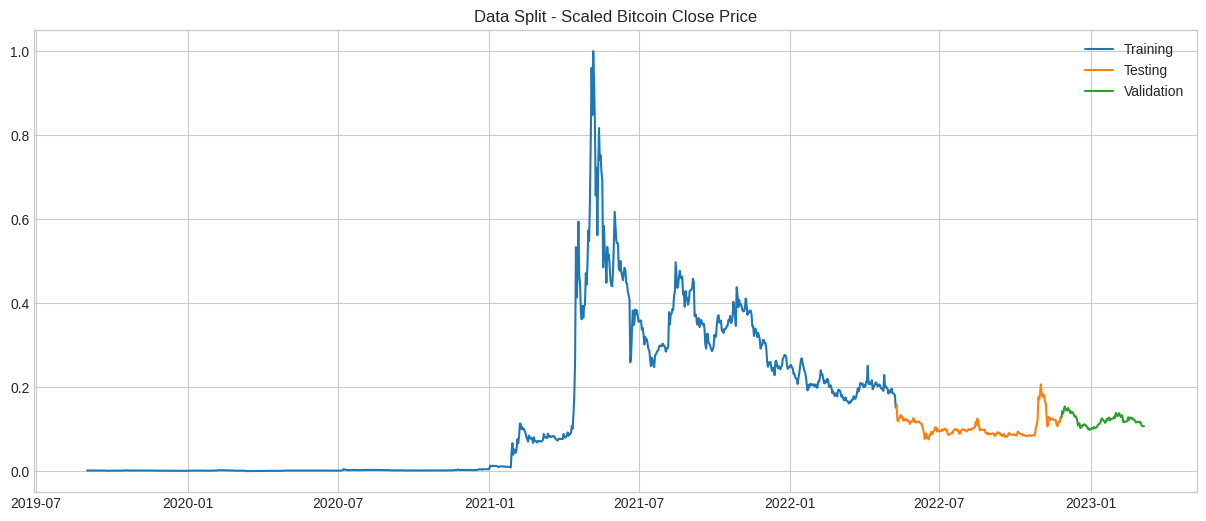

In [ ]:
plt.figure(figsize=(15,6))

scaled_btc_df = scaled_df[scaled_df.name=="Bitcoin"]

# Plotting the training, testing, and validation splits for scaled Bitcoin Close price.
plt.plot(scaled_df.Close[:983], label="Training")
plt.plot(scaled_df.Close[982:1183], label="Testing")
plt.plot(scaled_df.Close[1182:1283], label="Validation")
plt.legend()
plt.title("Data Split - Scaled Bitcoin Close Price")

# **Model**

# First Attempt

The current focus is on Bitcoin, aiming to predict its next day's closing price using data from the past 60 days. The predictive model will incorporate five key features: close, open, high, low, and trading volume, with the closing price as the target variable. An LSTM model, which is a type of recurrent neural network, will be employed through the TensorFlow Keras framework. Since the prediction involves a continuous variable, mean squared error will serve as the loss function, and Adam will be used as the optimizer for this task.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import SGD, Adam

# Constructing the LSTM model with two LSTM layers followed by dense layers.
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units = 50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.summary()
# Compiling the model with Adam optimizer and Mean Squared Error loss function.
lstm_model.compile(optimizer = Adam(learning_rate=0.01), loss = MeanSquaredError(), metrics=[RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,701
Trainable params: 32,701
Non-trainable params: 0
_________________________________________________________________


The model is designed with four layers, comprising two LSTM layers (each with 50 units) and two dense layers, one with 25 units and the other serving as the output layer. The initial LSTM layer takes in a sequence of data spanning 60 days across 5 features, outputting a sequence of the same length. This sequence is subsequently processed through the dense layers, culminating in a single-unit output that represents the predicted value.

## Training

In [ ]:
history1 = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
31/31 [==============================] - 7s 105ms/step - loss: 0.0411 - root_mean_squared_error: 0.2028 - val_loss: 3.6349e-04 - val_root_mean_squared_error: 0.0191
Epoch 2/50
31/31 [==============================] - 3s 109ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 2.5603e-04 - val_root_mean_squared_error: 0.0160
Epoch 3/50
31/31 [==============================] - 2s 71ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 4.8704e-04 - val_root_mean_squared_error: 0.0221
Epoch 4/50
31/31 [==============================] - 2s 70ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 2.2539e-04 - val_root_mean_squared_error: 0.0150
Epoch 5/50
31/31 [==============================] - 4s 123ms/step - loss: 9.6892e-04 - root_mean_squared_error: 0.0311 - val_loss: 2.0841e-04 - val_root_mean_squared_error: 0.0144
Epoch 6/50
31/31 [==============================] - 6s 179ms/step - loss: 9.3804e-04 - root_mean_squared_error: 0.0306

In [ ]:
history1.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

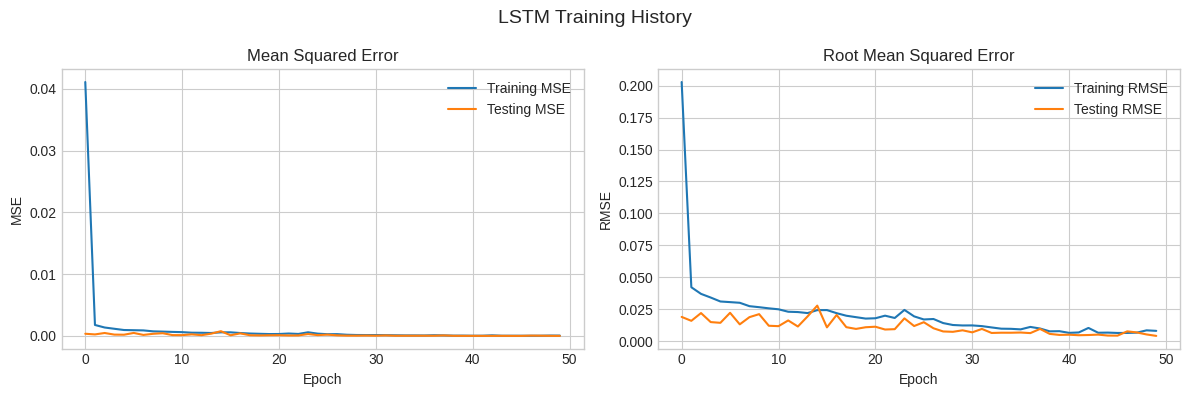

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Plotting training and testing Mean Squared Error (MSE) across epochs.
plt.subplot(121)
plt.plot(history1.history['loss'], label = "Training MSE")
plt.plot(history1.history['val_loss'], label = "Testing MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Mean Squared Error")
plt.legend()

# Plotting training and testing Root Mean Squared Error (RMSE) across epochs.
plt.subplot(122)
plt.plot(history1.history['root_mean_squared_error'], label = "Training RMSE")
plt.plot(history1.history['val_root_mean_squared_error'], label = "Testing RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error")
plt.legend()
plt.suptitle("LSTM Training History", fontsize=14)
plt.tight_layout()

## Next-Day Prediction

Following the model training, evaluating its performance using unseen data is a crucial step. The validation set, which comprises price data from a period starting 200 days beyond the final date in the training dataset, serves this purpose. This set was not employed during the training phase. Predictions were generated based on publicly accessible market data, including the opening and closing prices, highs, lows, and trading volumes. The objective was to forecast the closing price over a span of 100 days, approximately covering the period from May to August 2023. The outcomes of this predictive exercise are outlined below:

4/4 [==============================] - 0s 29ms/step


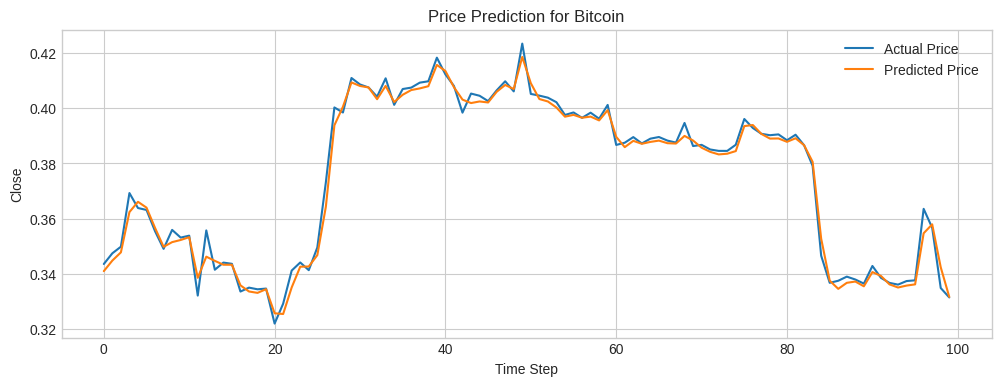

In [ ]:
def prediction_plot(actual, predicted, name = "Bitcoin"):
  plt.figure(figsize=(12,4))
  plt.plot(actual, label='Actual Price')
  plt.plot(predicted, label='Predicted Price')
  plt.title('Price Prediction for {0}'.format(name))
  plt.xlabel('Time Step')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

# Generating predictions for the validation dataset.
btc_predicted = lstm_model.predict(X_valid)

# Plotting the actual vs predicted prices for Bitcoin.
prediction_plot(y_valid, btc_predicted)

The model effectively captures the price movements, accurately forecasting trends despite Bitcoin's volatile price fluctuations. A notable limitation is the occasional delay in predictions, which may hinder its applicability for real-time trading, as it primarily forecasts the next day's prices. Nonetheless, it serves as a valuable instrument for predicting short-term trends.

## Single-Feature Model

Having conducted predictions with the initial five input features, interest shifts towards the model's performance when restricted to a single feature: the closing price over the last 60 days as a predictor for the next day's closing price. The model structure remains largely unchanged, with a minor adjustment to the input layer configuration. The outcomes of this focused analysis are detailed below:

In [ ]:
# Utilizing only the last column (close price) for both input and output to predict next day's close price using past 60 days.
X_train, y_train = get_Xy(X_data = btc_train_Xy[:,-1], y_data = btc_train_Xy[:,-1], n=60)  
X_test, y_test = get_Xy(X_data = btc_test_Xy[:,-1], y_data = btc_test_Xy[:,-1], n=60)
X_valid, y_valid = get_Xy(X_data = btc_valid_Xy[:,-1], y_data = btc_valid_Xy[:,-1], n=60)

(983, 60)
(200, 60)
(100, 60)


In [ ]:
# Constructing a second LSTM model to predict close price using only the close price feature from the last 60 days.
lstm_model2 = Sequential()
lstm_model2.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model2.add(LSTM(units = 50, return_sequences=False))
lstm_model2.add(Dense(25))
lstm_model2.add(Dense(1))

lstm_model2.summary()
lstm_model2.compile(optimizer = Adam(learning_rate=0.01), loss = MeanSquaredError(), metrics=[RootMeanSquaredError()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = lstm_model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
31/31 [==============================] - 15s 110ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 4.4941e-04 - val_root_mean_squared_error: 0.0212
Epoch 2/50
31/31 [==============================] - 2s 77ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 1.5366e-04 - val_root_mean_squared_error: 0.0124
Epoch 3/50
31/31 [==============================] - 3s 94ms/step - loss: 8.2939e-04 - root_mean_squared_error: 0.0288 - val_loss: 1.7903e-04 - val_root_mean_squared_error: 0.0134
Epoch 4/50
31/31 [==============================] - 4s 121ms/step - loss: 6.5031e-04 - root_mean_squared_error: 0.0255 - val_loss: 1.1721e-04 - val_root_mean_squared_error: 0.0108
Epoch 5/50
31/31 [==============================] - 2s 78ms/step - loss: 5.7344e-04 - root_mean_squared_error: 0.0239 - val_loss: 1.0653e-04 - val_root_mean_squared_error: 0.0103
Epoch 6/50
31/31 [==============================] - 4s 115ms/step - loss: 4.7824e-04 - root_mean_squared_error

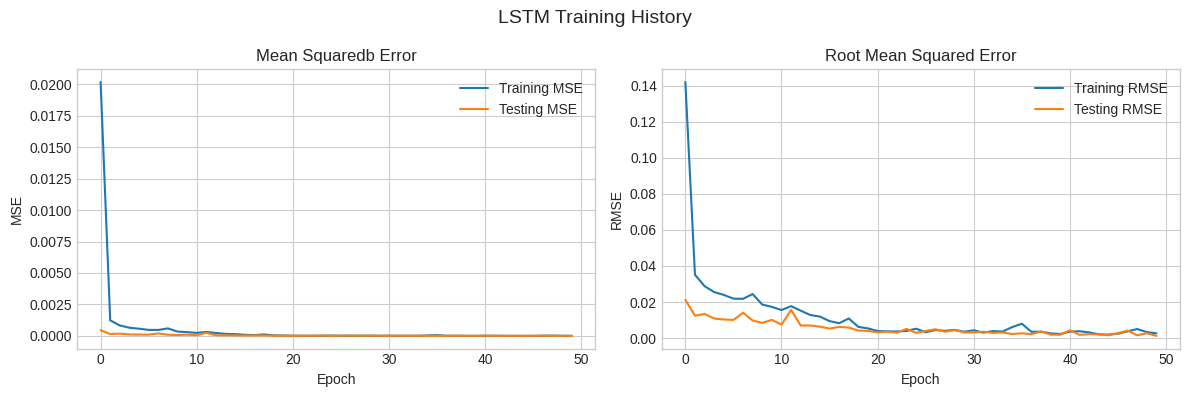

In [ ]:
# Setting up the figure to display the model's training history for both Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).
plt.figure(figsize=(12,4))

# Plotting training and testing Mean Squared Error to evaluate model performance over epochs.
plt.subplot(121)
plt.plot(history2.history['loss'], label = "Training MSE")
plt.plot(history2.history['val_loss'], label = "Testing MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Mean Squared Error")
plt.legend()

# Plotting training and testing Root Mean Squared Error for a clearer picture of the model's prediction accuracy.
plt.subplot(122)
plt.plot(history2.history['root_mean_squared_error'], label = "Training RMSE")
plt.plot(history2.history['val_root_mean_squared_error'], label = "Testing RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error")
plt.legend()
plt.suptitle("LSTM Training History Using Single Feature", fontsize=14)
plt.tight_layout()

4/4 [==============================] - 2s 32ms/step


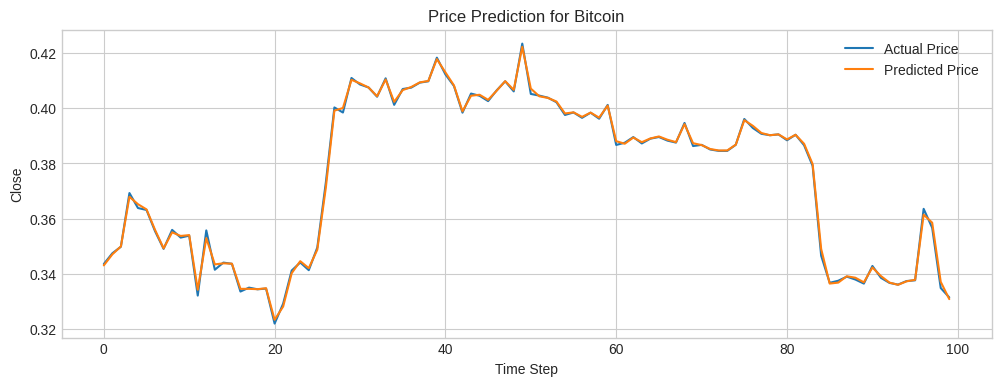

In [ ]:
btc_predicted2 = lstm_model2.predict(X_valid)
prediction_plot(y_valid, btc_predicted2)

The results from this model surprisingly outperform the earlier one, suggesting that the additional information included previously might not have been ideally suited for the prediction task. Alternatively, it could indicate a need for further refinement of the parameters in the initial model.